In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import qutip as qt
plt.style.use(['science', 'ieee'])
plt.style.use('science')
qt.settings.auto_tidyup = True
import os

In [27]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

# Comparison

In [5]:
times = np.linspace(0, 0.1, 100)

In [6]:
def single_mode_solver(method, dims, alpha_in, gamma_1, Gamma, U, times = times):
    sigma_1 = (3 * U) / 8 
    sigma_2 = U / 2
    sigma_3 = (-3 * U) / 8 
    gamma_2 = (U**2)/(16 * (Gamma + gamma_1))
    gamma_3 = (U**2)/(4 * (Gamma + gamma_1))
    
    psi0 = qt.coherent(dims, alpha_in, method="analytic")
#     times = np.linspace(0, 10, 100)

    s_minus = qt.destroy(dims)
    n_minus = s_minus.dag() * s_minus
    c_op_list = [np.sqrt(gamma_1) * s_minus, np.sqrt(gamma_2) * s_minus**2, np.sqrt(gamma_3) *  n_minus * s_minus]
    H = sigma_1 * (n_minus**2) + sigma_3 * n_minus # possibly I need to scale H by hbar or something
#     e_op_list = []

#     opts = Options()
#     opts.nsteps = 3000
    if method == "me":
        rho0 = qt.ket2dm(psi0)
        e_op_list = []
        return qt.mesolve(H, rho0, times, c_op_list, e_op_list).states
    elif method == "mc":
#         ntraj = 500
        e_op_list = [n_minus]
        return qt.mcsolve(H, psi0, times, c_op_list, [n_minus, n_minus**2], ntraj=250)

In [7]:
def two_mode_solver(method, dims, alpha_in, gamma_1, Gamma, U, times = times, ntraj=250):
    # quantities with optimal couplings chosen
    sigma_1 = (3 * U) / 8 
    sigma_2 = U / 2
    sigma_3 = (-3 * U) / 8 
    sigma_4 = (sigma_2/4)
    sigma_5 = U/4
    
    newgamma2 = (Gamma + gamma_1)
    
#     gamma_2 = (U**2)/(16 * (Gamma + gamma_1))

    # single-mode operators
    a = qt.destroy(dims)
    ad = a.dag()
    n = qt.num(dims)
    one = qt.qeye(dims)
    
    # composite-mode operatos
        # let s_minus be mode 1 and s_plus be mode 2 (for similarity with mathematica code)

    s_minus = qt.tensor(a, one)
    s_minus_dag = s_minus.dag()
    s_plus = qt.tensor(one, a)
    s_plus_dag = s_plus.dag()
    
    n_minus = qt.tensor(n, one)
    n_plus = qt.tensor(one, n)
    
    # list of collapse operators
    c_op_list = [np.sqrt(gamma_1) * s_minus, np.sqrt(newgamma2) * s_plus]
    
    # defining Hamiltonian
    H_self = sigma_1 * (n_plus * n_plus + n_minus * n_minus) + sigma_2 * n_plus * n_minus + sigma_3 * (n_plus + n_minus)
    H_int = sigma_4 * (s_plus_dag * s_minus)*(s_plus_dag * s_minus) + sigma_5 * s_plus_dag * s_minus * (n_minus - n_plus - 1)
    H_int_hc = sigma_4 * (s_minus_dag * s_plus) * (s_minus_dag * s_plus) + sigma_5 * s_minus_dag * s_plus * (n_minus - n_plus - 1)
    H = H_self + H_int + H_int_hc
    
    e_op_list = [n_minus, n_plus]
    
    # let's put a coherent state into mode s_-
    psi_s_minus = qt.coherent(dims, alpha_in, method="analytic")
    vac = qt.basis(dims, 0)
    psi0 = qt.tensor(psi_s_minus, vac)
    
    return qt.mcsolve(H, psi0, times, c_op_list, e_op_list, ntraj=ntraj)

In [ ]:
# def single_mode_solver(method, dims, alpha_in, gamma_1, Gamma, U, times = np.linspace(0, 0.02, 100)):
# def two_mode_solver(method, dims, alpha_in, gamma_1, Gamma, U, times = np.linspace(0, 0.02, 100), ntraj=250):

In [ ]:
# sol300 = single_mode_solver("mc", 364, np.sqrt(300), 0.0, 432.0, 2.0)

In [9]:
# universal parameters
gamma_1 = 10.0
Gamma = 432.0
U = 2.0

In [10]:
qt.coherent_dm(50, 5, method="analytic").norm()

0.999993198910696

In [11]:
folderout = os.getcwd() + "\\two_mode_state_out\\"
if os.path.isdir(folderout)==False:
    os.mkdir(folderout)
    print("Folder created")
# else:
#     print("Folder exists")
    
# fileout = folderout+"two_mode_solver-dims=" + str(dims)+",alpha="+str(alpha_in)+".dat"

# qt.qsave(sol_test_2, fileout)
# print(fileout)

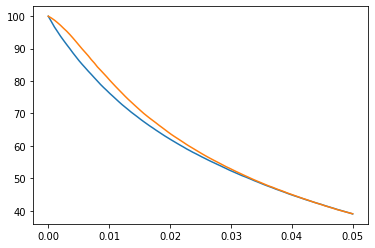

In [50]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(times, sol_test_1.expect[0])
ax.plot(times, myin.expect[0])

In [12]:
def myfileout(alpha_in, dims):
    return folderout+"two_mode_solver-dims=" + str(dims)+",alpha="+str(alpha_in)+".dat"

In [13]:
dims = 50
alpha_in = 5.0
sol_25_1 = single_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
sol_25_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

qt.qsave(sol_25_2, myfileout(alpha_in, dims))

10.0%. Run time:   2.67s. Est. time left: 00:00:00:24
20.0%. Run time:   2.84s. Est. time left: 00:00:00:11
30.0%. Run time:   2.99s. Est. time left: 00:00:00:06
40.0%. Run time:   3.14s. Est. time left: 00:00:00:04
50.0%. Run time:   3.29s. Est. time left: 00:00:00:03
60.0%. Run time:   3.46s. Est. time left: 00:00:00:02
70.0%. Run time:   3.62s. Est. time left: 00:00:00:01
80.0%. Run time:   3.77s. Est. time left: 00:00:00:00
90.0%. Run time:   3.93s. Est. time left: 00:00:00:00
100.0%. Run time:   4.08s. Est. time left: 00:00:00:00
Total run time:   4.20s
10.0%. Run time:   4.17s. Est. time left: 00:00:00:37
20.0%. Run time:   7.08s. Est. time left: 00:00:00:28
30.0%. Run time:   9.51s. Est. time left: 00:00:00:22
40.0%. Run time:  11.97s. Est. time left: 00:00:00:17
50.0%. Run time:  14.55s. Est. time left: 00:00:00:14
60.0%. Run time:  16.93s. Est. time left: 00:00:00:11
70.0%. Run time:  19.28s. Est. time left: 00:00:00:08
80.0%. Run time:  21.85s. Est. time left: 00:00:00:05
90.

In [18]:
qt.coherent_dm(260, np.sqrt(200), method="analytic").norm()

1.0000466160697108

In [19]:
dims = 200
alpha_in = np.sqrt(150)
sol_150_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

qt.qsave(sol_150_2, myfileout(np.round(alpha_in), dims))

10.0%. Run time: 653.77s. Est. time left: 00:01:38:03
20.0%. Run time: 1216.29s. Est. time left: 00:01:21:05
30.0%. Run time: 1784.06s. Est. time left: 00:01:09:22
40.0%. Run time: 2370.53s. Est. time left: 00:00:59:15
50.0%. Run time: 2943.69s. Est. time left: 00:00:49:03
60.0%. Run time: 3548.87s. Est. time left: 00:00:39:25
70.0%. Run time: 4119.88s. Est. time left: 00:00:29:25
80.0%. Run time: 4689.32s. Est. time left: 00:00:19:32
90.0%. Run time: 5276.75s. Est. time left: 00:00:09:46
100.0%. Run time: 5825.98s. Est. time left: 00:00:00:00
Total run time: 5826.10s


In [20]:
dims = 260
alpha_in = np.sqrt(200)
sol_200_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

qt.qsave(sol_200_2, myfileout(np.round(alpha_in), dims))

10.0%. Run time: 1628.30s. Est. time left: 00:04:04:14
20.0%. Run time: 3063.03s. Est. time left: 00:03:24:12
30.0%. Run time: 4457.07s. Est. time left: 00:02:53:19
40.0%. Run time: 5878.50s. Est. time left: 00:02:26:57
50.0%. Run time: 7489.07s. Est. time left: 00:02:04:49
60.0%. Run time: 8900.03s. Est. time left: 00:01:38:53
70.0%. Run time: 10318.25s. Est. time left: 00:01:13:42
80.0%. Run time: 11721.18s. Est. time left: 00:00:48:50
90.0%. Run time: 13289.37s. Est. time left: 00:00:24:36
100.0%. Run time: 14596.86s. Est. time left: 00:00:00:00
Total run time: 14596.93s


In [21]:
dims = 364
alpha_in = np.sqrt(300)
# sol_300_1 = single_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
sol_300_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

qt.qsave(sol_300_2, myfileout(np.round(alpha_in), dims))

10.0%. Run time: 5241.92s. Est. time left: 00:13:06:17
20.0%. Run time: 9814.76s. Est. time left: 00:10:54:19
30.0%. Run time: 14373.15s. Est. time left: 00:09:18:57
40.0%. Run time: 18943.14s. Est. time left: 00:07:53:34
50.0%. Run time: 24028.71s. Est. time left: 00:06:40:28
60.0%. Run time: 28586.34s. Est. time left: 00:05:17:37
70.0%. Run time: 33272.08s. Est. time left: 00:03:57:39
80.0%. Run time: 38000.88s. Est. time left: 00:02:38:20
90.0%. Run time: 42810.44s. Est. time left: 00:01:19:16
100.0%. Run time: 47238.18s. Est. time left: 00:00:00:00
Total run time: 47238.26s


In [22]:
dims = 581
alpha_in = np.sqrt(500)
# sol_500_1 = single_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
sol_500_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

qt.qsave(sol_500_2, myfileout(np.round(alpha_in), dims))

10.0%. Run time: 27217.86s. Est. time left: 02:20:02:40
20.0%. Run time: 51012.72s. Est. time left: 02:08:40:50
30.0%. Run time: 74786.22s. Est. time left: 02:00:28:21


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [30]:
# dims = 140
# alpha_in = 10.0

# sol_10_1 = single_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
# sol_10_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

10.0%. Run time:  12.48s. Est. time left: 00:00:01:52
20.0%. Run time:  13.97s. Est. time left: 00:00:00:55
30.0%. Run time:  15.33s. Est. time left: 00:00:00:35
40.0%. Run time:  16.69s. Est. time left: 00:00:00:25
50.0%. Run time:  18.20s. Est. time left: 00:00:00:18
60.0%. Run time:  20.03s. Est. time left: 00:00:00:13
70.0%. Run time:  21.49s. Est. time left: 00:00:00:09
80.0%. Run time:  23.09s. Est. time left: 00:00:00:05
90.0%. Run time:  24.58s. Est. time left: 00:00:00:02
100.0%. Run time:  26.00s. Est. time left: 00:00:00:00
Total run time:  26.07s


# Making the graph

## Loading 2mode and running 1 mode

In [37]:
def single_mode_solver(method, dims, alpha_in, gamma_1, Gamma, U, times = times):
    sigma_1 = (3 * U) / 8 
    sigma_2 = U / 2
    sigma_3 = (-3 * U) / 8 
    gamma_2 = (U**2)/(16 * (Gamma + gamma_1))
    gamma_3 = (U**2)/(4 * (Gamma + gamma_1))
    
    psi0 = qt.coherent(dims, alpha_in, method="analytic")
#     times = np.linspace(0, 10, 100)

    s_minus = qt.destroy(dims)
    n_minus = s_minus.dag() * s_minus
    c_op_list = [np.sqrt(gamma_1) * s_minus, np.sqrt(gamma_2) * s_minus**2, np.sqrt(gamma_3) *  n_minus * s_minus]
    H = sigma_1 * (n_minus**2) + sigma_3 * n_minus # possibly I need to scale H by hbar or something
#     e_op_list = []

#     opts = Options()
#     opts.nsteps = 3000
    if method == "me":
        rho0 = qt.ket2dm(psi0)
        e_op_list = []
        return qt.mesolve(H, rho0, times, c_op_list, e_op_list).states
    elif method == "mc":
#         ntraj = 500
        e_op_list = [n_minus]
        return qt.mcsolve(H, psi0, times, c_op_list, [n_minus, n_minus**2], ntraj=500)

In [6]:
folderout = os.getcwd() + "\\two_mode_state_out\\"
def myfileout(alpha_in, dims):
    return folderout+"two_mode_solver-dims=" + str(dims)+",alpha="+str(alpha_in)+".dat"

def myfilein(alpha_in, dims):
    _filein = myfileout(np.round(alpha_in), dims)
    return qt.qload(_filein)
    

In [19]:
# universal parameters
gamma_1 = 10.0
Gamma = 432.0
U = 2.0
times = np.linspace(0, 0.1, 100)

In [38]:
dims = 50
alpha_in = 5.0
sol_25_1 = single_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
# sol_25_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
sol_25_2 = myfilein(alpha_in, dims)


10.0%. Run time:  33.37s. Est. time left: 00:00:05:00
20.0%. Run time:  33.69s. Est. time left: 00:00:02:14
30.0%. Run time:  34.01s. Est. time left: 00:00:01:19
40.0%. Run time:  34.34s. Est. time left: 00:00:00:51
50.0%. Run time:  34.67s. Est. time left: 00:00:00:34
60.0%. Run time:  35.02s. Est. time left: 00:00:00:23
70.0%. Run time:  35.36s. Est. time left: 00:00:00:15
80.0%. Run time:  35.69s. Est. time left: 00:00:00:08
90.0%. Run time:  36.09s. Est. time left: 00:00:00:04
100.0%. Run time:  36.46s. Est. time left: 00:00:00:00
Total run time:  36.61s
Loaded Result object:
Result object with mcsolve data.
--------------------------------
expect = True
num_expect = 2, num_collapse = 2, ntraj = 250


In [39]:
dims = 200
alpha_in = np.sqrt(150)
sol_150_1 = single_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
# sol_150_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

# qt.qsave(sol_150_2, myfileout(np.round(alpha_in), dims))

sol_150_2 = myfilein(alpha_in, dims)

10.0%. Run time:   8.21s. Est. time left: 00:00:01:13
20.0%. Run time:  11.55s. Est. time left: 00:00:00:46
30.0%. Run time:  14.75s. Est. time left: 00:00:00:34
40.0%. Run time:  17.59s. Est. time left: 00:00:00:26
50.0%. Run time:  20.35s. Est. time left: 00:00:00:20
60.0%. Run time:  23.57s. Est. time left: 00:00:00:15
70.0%. Run time:  25.98s. Est. time left: 00:00:00:11
80.0%. Run time:  28.41s. Est. time left: 00:00:00:07
90.0%. Run time:  30.76s. Est. time left: 00:00:00:03
100.0%. Run time:  33.15s. Est. time left: 00:00:00:00
Total run time:  33.23s
Loaded Result object:
Result object with mcsolve data.
--------------------------------
expect = True
num_expect = 2, num_collapse = 2, ntraj = 250


In [40]:
dims = 260
alpha_in = np.sqrt(200)
sol_200_1 = single_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
# sol_200_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

# qt.qsave(sol_200_2, myfileout(np.round(alpha_in), dims))

sol_200_2 = myfilein(alpha_in, dims)

10.0%. Run time:   6.64s. Est. time left: 00:00:00:59
20.0%. Run time:   9.75s. Est. time left: 00:00:00:39
30.0%. Run time:  13.26s. Est. time left: 00:00:00:30
40.0%. Run time:  17.20s. Est. time left: 00:00:00:25
50.0%. Run time:  21.14s. Est. time left: 00:00:00:21
60.0%. Run time:  25.03s. Est. time left: 00:00:00:16
70.0%. Run time:  28.86s. Est. time left: 00:00:00:12
80.0%. Run time:  32.53s. Est. time left: 00:00:00:08
90.0%. Run time:  36.40s. Est. time left: 00:00:00:04
100.0%. Run time:  40.04s. Est. time left: 00:00:00:00
Total run time:  40.16s
Loaded Result object:
Result object with mcsolve data.
--------------------------------
expect = True
num_expect = 2, num_collapse = 2, ntraj = 250


In [41]:
dims = 364
alpha_in = np.sqrt(300)
sol_300_1 = single_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)
# sol_300_2 = two_mode_solver("mc", dims, alpha_in, gamma_1, Gamma, U)

# qt.qsave(sol_300_2, myfileout(np.round(alpha_in), dims))

sol_300_2 = myfilein(alpha_in, dims)

10.0%. Run time:   9.60s. Est. time left: 00:00:01:26
20.0%. Run time:  15.70s. Est. time left: 00:00:01:02
30.0%. Run time:  21.65s. Est. time left: 00:00:00:50
40.0%. Run time:  27.55s. Est. time left: 00:00:00:41
50.0%. Run time:  33.91s. Est. time left: 00:00:00:33
60.0%. Run time:  42.33s. Est. time left: 00:00:00:28
70.0%. Run time:  51.04s. Est. time left: 00:00:00:21
80.0%. Run time:  58.98s. Est. time left: 00:00:00:14
90.0%. Run time:  67.15s. Est. time left: 00:00:00:07
100.0%. Run time:  75.32s. Est. time left: 00:00:00:00
Total run time:  75.35s
Loaded Result object:
Result object with mcsolve data.
--------------------------------
expect = True
num_expect = 2, num_collapse = 2, ntraj = 250


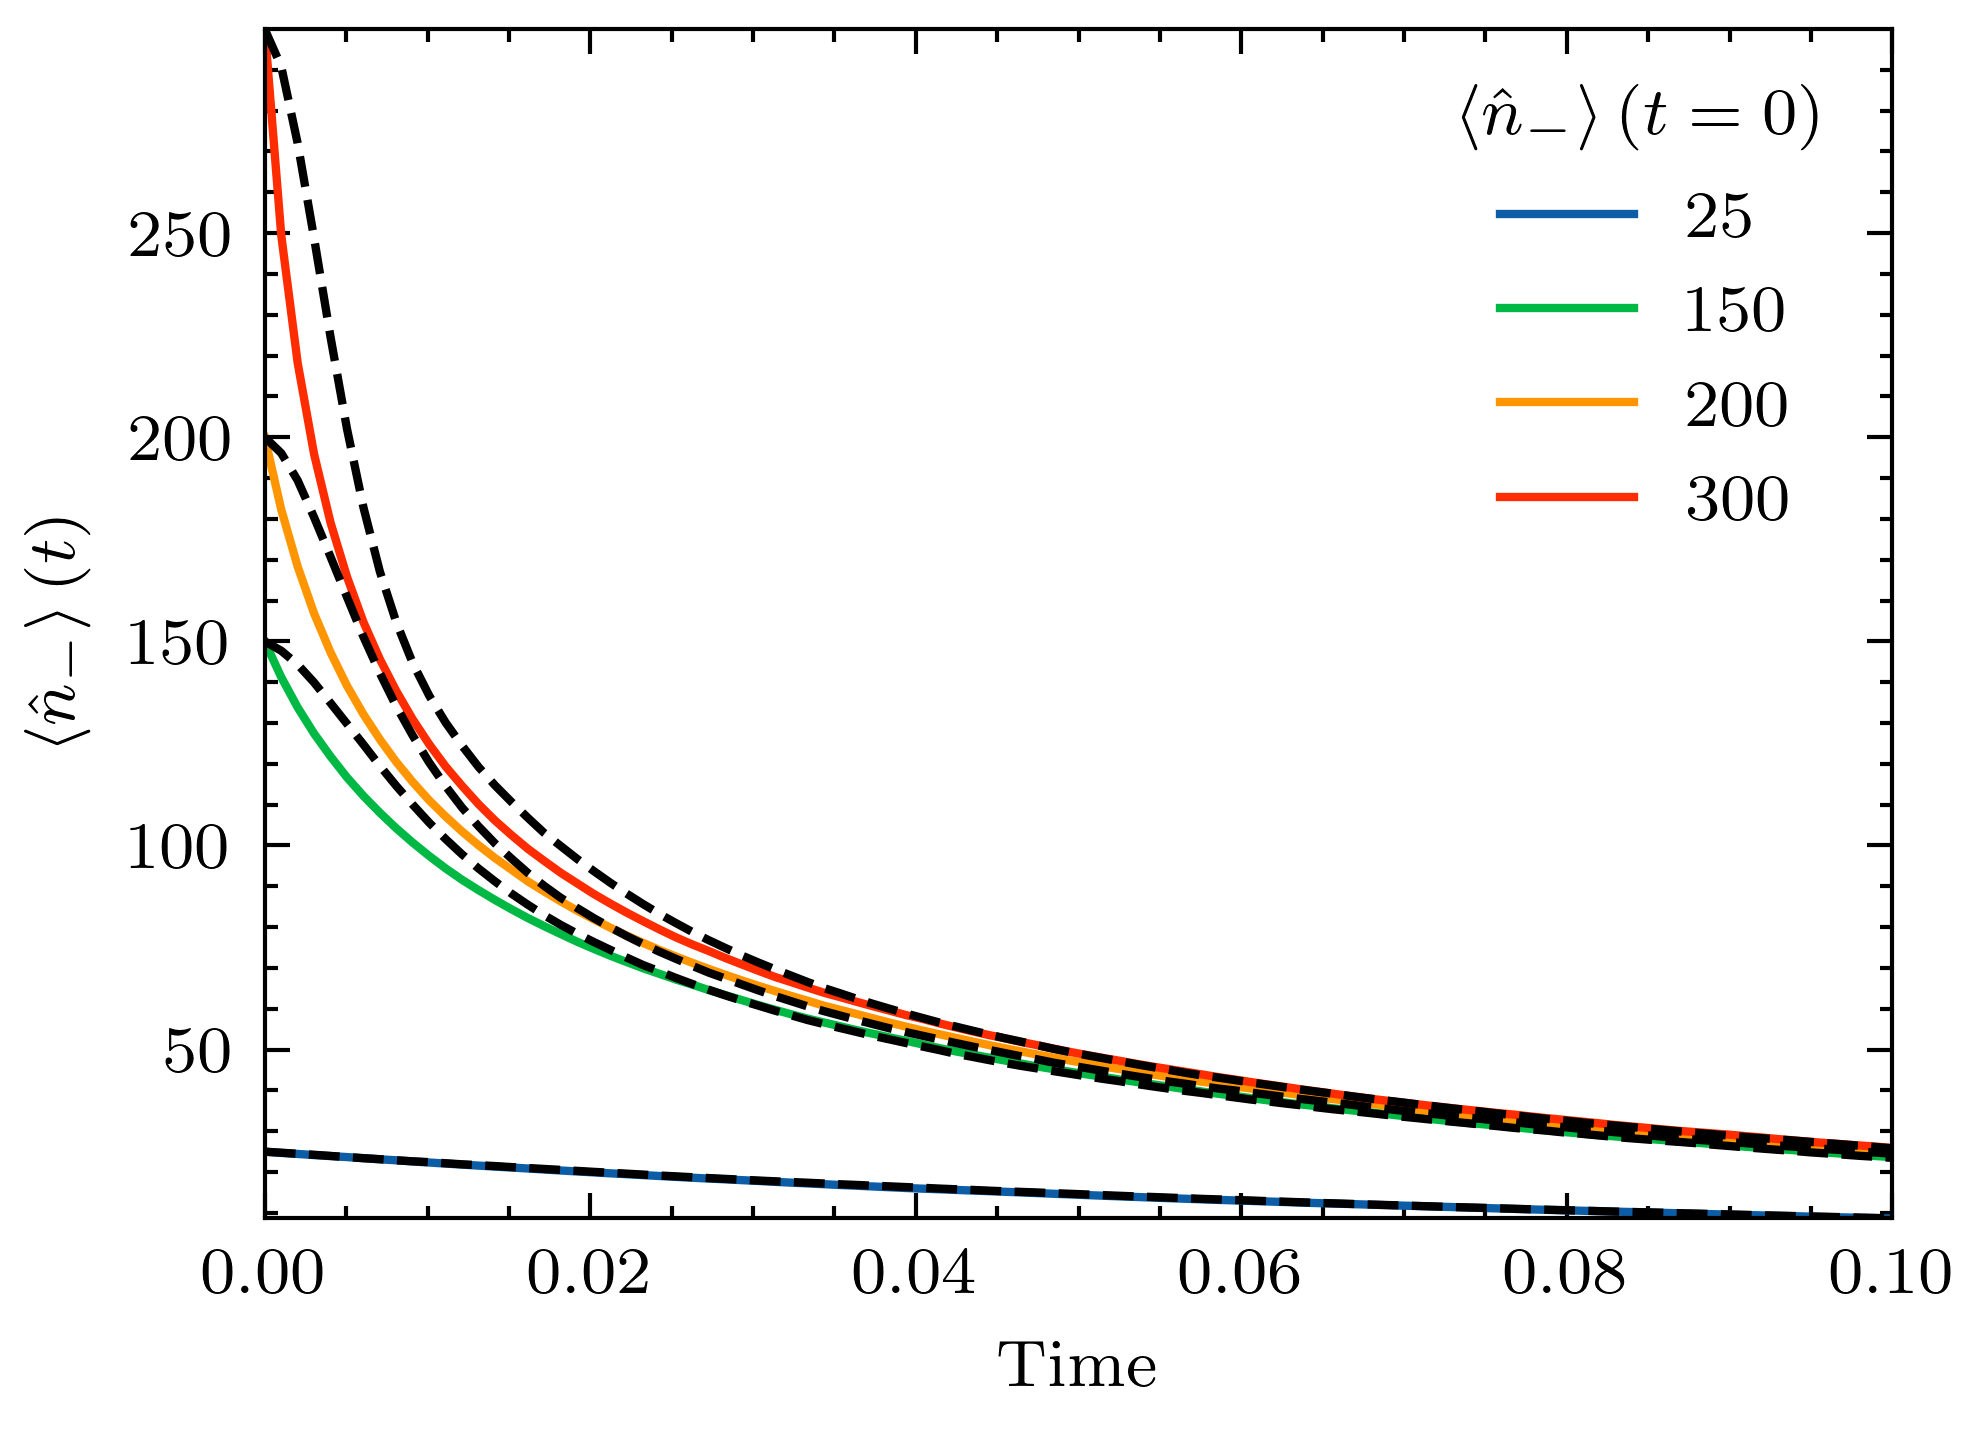

In [33]:
fig, ax = plt.subplots()

ax.plot(times, sol_25_1.expect[0], label="$25$")
ax.plot(times, sol_150_1.expect[0], label="$150$")
ax.plot(times, sol_200_1.expect[0], label="$200$")
ax.plot(times, sol_300_1.expect[0], label="$300$")

ax.plot(times, sol_25_2.expect[0], linestyle="--", color="black")
ax.plot(times, sol_150_2.expect[0], linestyle="--", color="black")
ax.plot(times, sol_200_2.expect[0], linestyle="--", color="black")
ax.plot(times, sol_300_2.expect[0], linestyle="--", color="black")


ax.set(xlabel="Time")
ax.set(ylabel="$\\langle \\hat{n}_-\\rangle\\left( t\\right)$")
ax.legend(title = "$\\langle \\hat{n}_- \\rangle \\left(t=0\\right)$", loc=0)
ax.autoscale(tight=True)

# fig.savefig("NL_decay_two_mode_one_mode_comparison.pdf")
# fig.savefig("NL_decay_two_mode_one_mode_comparison.png", dpi=300)

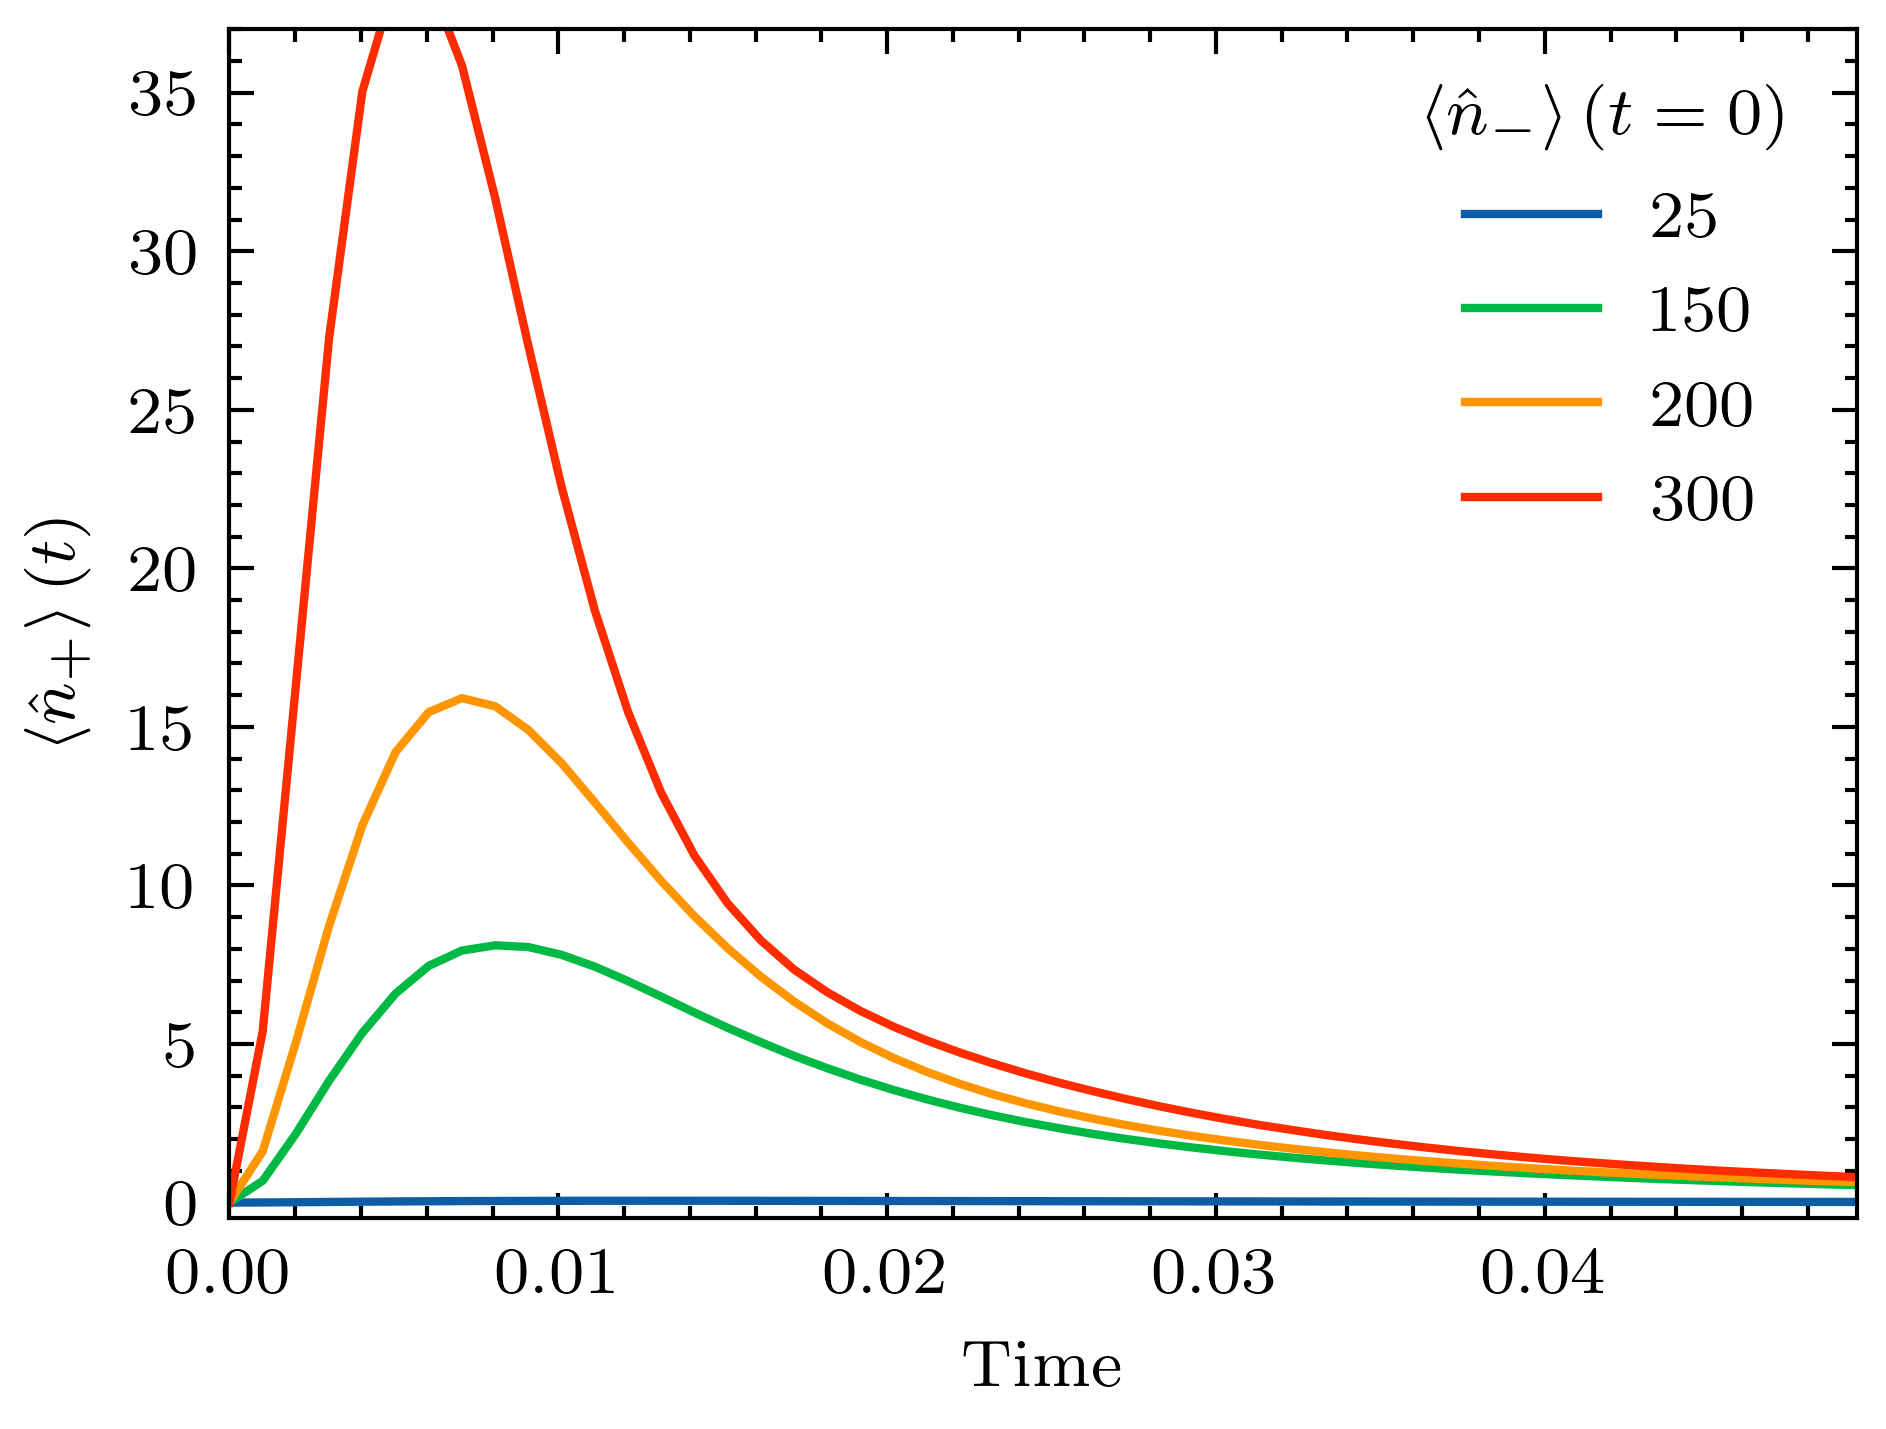

In [50]:
fig, ax = plt.subplots()

ax.plot(times[:50], sol_25_2.expect[1][:50], label="$25$")
ax.plot(times[:50], sol_150_2.expect[1][:50], label="$150$")
ax.plot(times[:50], sol_200_2.expect[1][:50], label="$200$")
ax.plot(times[:50], sol_300_2.expect[1][:50], label="$300$")

# ax.plot(times, sol_25_2.expect[1], linestyle="--", color="black")
# ax.plot(times, sol_150_2.expect[1], linestyle="--", color="black")
# ax.plot(times, sol_200_2.expect[1], linestyle="--", color="black")
# ax.plot(times, sol_300_2.expect[1], linestyle="--", color="black")


ax.set(xlabel="Time")
ax.set(ylabel="$\\langle \\hat{n}_+\\rangle\\left( t\\right)$")
ax.legend(title = "$\\langle \\hat{n}_- \\rangle \\left(t=0\\right)$", loc=0)
ax.autoscale(tight=True)
ax.set(ylim=[-0.5, 37])

fig.savefig("two_mode_model_splus.pdf")
fig.savefig("two_mode_model_splus.png", dpi=300)